In [2]:
import numpy as np
import gurobipy as gp
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('price_demand_data.csv')
df.describe()

,price,demand
count,99.000000,99.000000
mean,1.017677,532.828283
std,0.140726,244.150382
min,0.760000,87.000000
25%,0.900000,346.000000
50%,1.040000,490.000000
75%,1.135000,731.000000
max,1.250000,1213.000000


#### 1. Fit a linear regression model to price_demand data set

In [4]:
y = df['demand']
X = df[['price']]

lm = LinearRegression().fit(X, y)
lm.coef_; lm.intercept_

1924.7175435291088

In [5]:
resids = y - lm.predict(X)

#### 2. Solve the optimal quantity to produce when p=1.

In [6]:
# assume the price is p=1 and generate demand data.

price = 1
demand = []
for i in range(len(df)):
    demand += (price*lm.coef_ + lm.intercept_ + resids[i]).tolist()

demand[:5]

[351.3856262081299,
 579.5202466172364,
 472.21963007414547,
 448.937248550244,
 673.7489942009765]

In [7]:
# decision variables are (q, h1, h2, ..., h99)
nd = len(df)
c=0.5; g=0.75; t=0.15

obj = np.zeros(nd+1)
obj[1:] = 1.0/nd

# h is negative costs
lb = np.zeros(nd+1)
lb[1:] = -np.inf 
ub = np.zeros(nd+1)
ub[0] = np.inf 

rhs = np.zeros(2*nd)
direction = np.array(['>','<']*(nd))

In [8]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
    A[2*r,[0,r+1]] = [g-c,-1] # location 1 is q, location r+1 is this h
    rhs[2*r] = g*demand[r]
    A[2*r+1,[0,r+1]] = [c+t,1]
    rhs[2*r+1] = t*demand[r]

In [9]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

Academic license - for non-commercial use only - expires 2022-03-15
Using license file C:\Users\Elisha\gurobi.lic


In [10]:
spMod_x.x[0]  # the optimal quantity to produce is 471.86 when p=1.

471.8653795908935

In [11]:
spMod.objval

-325.5213527193693

#### 3. Now let price impact demand. Find out the optimal price and quantity to print.

In [26]:
# this function returns optimal price, quantity and profit.

def optimal(df, coef, intercept, residuals):
    
    # decision variables are (p, q, h1, h2, ..., h99)
    nd = len(df)
    c=0.5; g=0.75; t=0.15
    resids = residuals
    
    # obj is the linear term
    obj = np.zeros(nd+2)
    obj[2:] = 1.0/nd
    obj[0] = intercept + resids.mean() 
    
    # h is negative costs, p and q cannot be lower than zero
    lb = np.zeros(nd+2)
    lb[2:] = -np.inf
    ub = np.zeros(nd+2)
    ub[:2] = np.inf 
    
    rhs = np.zeros(2*nd)
    direction = np.array(['>','<']*(nd))
    
    # Q is quadratic term
    Q = np.zeros((nd+2,nd+2))
    Q[0,0] = coef
    
    A = np.zeros((2*nd,nd+2))
    for r in range(nd):
        A[2*r,[0,1,r+2]] = [-0.75*coef,g-c,-1] 
        # location 1 is p, location 2 is q, location r+2 is this h
        rhs[2*r] = g*(intercept + resids[r])
        A[2*r+1,[0,1,r+2]] = [-0.15*coef,c+t,1]
        rhs[2*r+1] = t*(intercept + resids[r])
    # print(A)
        
    spMod = gp.Model()
    spMod_x = spMod.addMVar(len(obj),lb=lb,ub=ub)
    spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs)
    spMod.setMObjective(Q,obj,0,sense=gp.GRB.MAXIMIZE)
    
    spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    spMod.optimize()
    
    return spMod_x.x[0], spMod_x.x[1], spMod.objval

In [27]:
price, quantity, profit = optimal(df, lm.coef_, lm.intercept_, resids)

In [28]:
print('Optimal Price:', price)
print('Optimal Quantity:', quantity)
print('Optimal Profit:', profit)

Optimal Price: 0.9536264966228527
Optimal Quantity: 535.2910009499728
Optimal Profit: 234.42493491247842


#### 4. How sensitive the optimal price and quantity are to the dataset.

In [38]:
optiPrice = []
optiQuantity = []
optiProfit = []

for num in range(1000):
    x = np.random.choice(df.index, size=len(df), replace=True).tolist()
    sample = df.loc[x]
    #display(sample)
    
    # get residuals
    y = sample['demand']
    X = sample[['price']]
    lm = LinearRegression().fit(X, y)
    a = lm.coef_
    b = lm.intercept_
    resids = y - lm.predict(X)
    resids.reset_index(drop=True, inplace=True)
    #display(resids)
    
    optiPrice.append(optimal(df, a, b, resids)[0])
    optiQuantity.append(optimal(df, a, b, resids)[1])
    optiProfit.append(optimal(df, a, b, resids)[2])

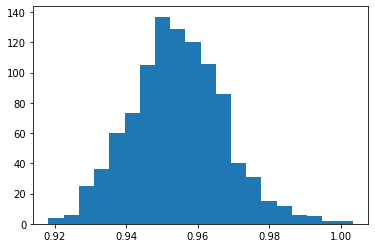

In [39]:
plt.hist(optiPrice, bins=20);

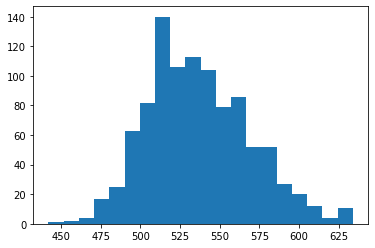

In [46]:
plt.hist(optiQuantity, bins=20);

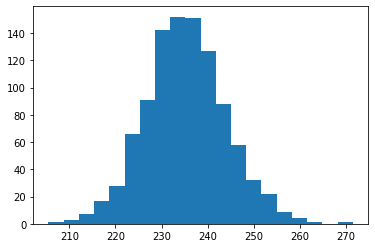

In [41]:
plt.hist(optiProfit, bins=20);

#### 5. Make a scatterplot with histograms on the x and y axis to show optimal price and quantity

In [47]:
optimal = pd.DataFrame()
optimal['Optimal_Price'] = optiPrice
optimal['Optimal_Quantity'] = optiQuantity
optimal['Optimal_Profit'] = optiProfit

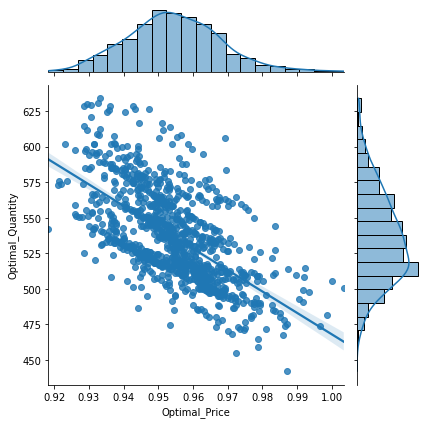

In [50]:
# https://datavizpyr.com/scatter-plot-with-marginal-histograms-in-python-with-seaborn/

sns.jointplot(x='Optimal_Price', 
              y='Optimal_Quantity',
              kind='reg',
              data=optimal,
              height=6, ratio=4,
              marginal_kws=dict(bins=20))

#plt.savefig("marginal_plot_Seaborn.png",figsize=(4,4), dpi=150)

#### 6. The standard NV model

In [12]:
# cost of underproduce

Cu = g - c
Cu

0.25

In [13]:
# cost of overproduce

Co = c + t
Co

0.65

In [14]:
# probability that demand is less or equal to production

Pr = Cu/(Cu+Co)
Pr

0.2777777777777778

In [21]:
import scipy.stats as st

z = st.norm.ppf(Pr) # get z score from cumulative distribution
z

-0.5894557978497783

In [23]:
Optimal_Q = df['demand'].mean() + z*df['demand'].std()
Optimal_Q

388.9124246629418

In [30]:
# calculater optimal profit with standard NV model

Optimal_P = np.zeros(len(df))
for i in range(len(df)):
    if Optimal_Q <= df['demand'][i]:
        daily_profit = df['price'][i] * df['demand'][i] - Optimal_Q*c - (df['demand'][i]-Optimal_Q)*g
    else:
        daily_profit = df['price'][i] * df['demand'][i] - Optimal_Q*c - (Optimal_Q-df['demand'][i])*t
    Optimal_P[i] = daily_profit

Optimal_P.mean()

183.2050738961797